# NYC High School Data Analysis

This analysis will seek to understand correlations between high school SAT scores and other variables such as gender, race, and location. The first few cells contain code that was provided automatically by Data Quest.

In [1]:
# read in the data
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d
    
# ignore the Jupyter warnings
import warnings
warnings.filterwarnings('ignore')

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

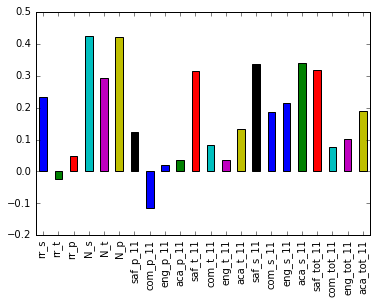

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline
combined.corr()['sat_score'][survey_fields].plot.bar()
plt.show()

# Bar chart findings

As seen in the visualization above, there is a fairly significant positive correlation between N_s and sat_score, as well as N_p and sat_score. Other significant positive correlations include saf_t_11, saf_s_11, aca_s_11, and saf_tot_11. This means that total enrollment, safety, and academic standards have a positive impact on SAT scores.

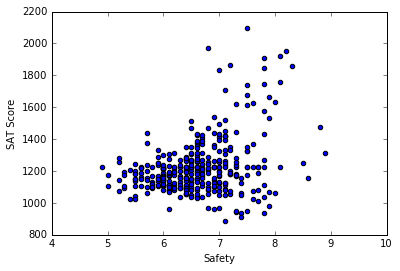

In [14]:
# create a scatter plot investigating safety vs sat scores
plt.scatter(combined['saf_s_11'], combined['sat_score'])
plt.xlabel('Safety')
plt.ylabel('SAT Score')
plt.show()

# Scatter plot findings

As seen in the scatter plot above, there is a weak positive correlation between Safety and SAT Score. Generally speaking, as safety increases, so does SAT score.

In [15]:
# compute the average safety score per district
safety_per_district = combined.groupby('school_dist').mean()
safety_per_district.reset_index(inplace=True)
safety_per_district[['school_dist', 'saf_s_11']]

,school_dist,saf_s_11
0,01,6.768611
1,02,6.910660
2,03,6.716667
3,04,6.885714
4,05,6.314286
5,06,6.950000
6,07,6.800000
7,08,6.364697
8,09,6.655000
9,10,6.577273


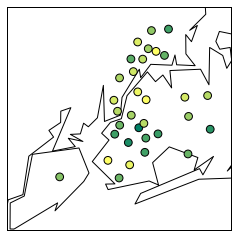

In [16]:
from mpl_toolkits.basemap import Basemap
# display map of safety score by district

# create Basemap object
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary()
m.drawcoastlines()
m.drawrivers()

longitudes = safety_per_district['lon'].tolist()
latitudes = safety_per_district['lat'].tolist()

m.scatter(longitudes, latitudes, zorder=2, latlon=True, c=safety_per_district['saf_s_11'], s=60, cmap='summer')

# Map analysis

As shown from the brighter (more yellow) dots in the map above, northern Manhattan and Brooklyn have some of the lower safety scores.

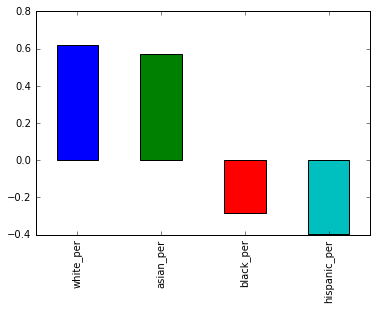

In [17]:
# create bar plots of correlation between race pertentages an SAT scores
race_columns = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()['sat_score'][race_columns].plot.bar()

# Bar plot analysis

As seen in the bar plot above, there is a strong positive correlation between SAT score and white per, as well as SAT score and Asian per. There is a strong negative correlation betwee SAT score and Hispanic per, and a weaker negative correlation between SAT score and black per.

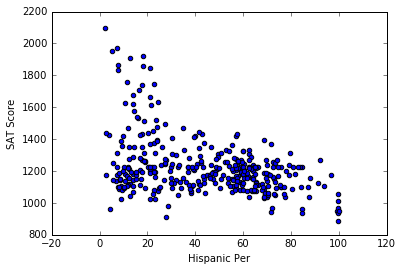

In [18]:
# scatter plot of Hispanic per and SAT score
plt.scatter(combined['hispanic_per'], combined['sat_score'])
plt.xlabel('Hispanic Per')
plt.ylabel('SAT Score')
plt.show()

# Scatter plot analysis

As shown in the scatter plot above, there is a fairly strong negative correlation between SAT score and Hispanic per. 

In [19]:
# analysis of high Hispanic per schools
high_hispanic_per = combined[combined['hispanic_per'] > 95]
high_hispanic_per[['SCHOOL NAME', 'hispanic_per']]

,SCHOOL NAME,hispanic_per
44,MANHATTAN BRIDGES HIGH SCHOOL,99.8
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,96.7
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,99.8
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,99.4
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,99.8
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,99.8
253,MULTICULTURAL HIGH SCHOOL,99.8
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,100.0


# High Hispanic per analysis

As shown in the table above, the schools listed seem to used mostly by international students.

In [20]:
# analysis of low Hispanic per and high SAT scores
low_hispanic_per_high_sat = combined[combined['hispanic_per'] < 10]
low_hispanic_per_high_sat = low_hispanic_per_high_sat[combined['sat_score'] > 1800]
low_hispanic_per_high_sat[['SCHOOL NAME', 'hispanic_per', 'sat_score']]

,SCHOOL NAME,hispanic_per,sat_score
37,STUYVESANT HIGH SCHOOL,2.4,2096.0
151,BRONX HIGH SCHOOL OF SCIENCE,7.2,1969.0
187,BROOKLYN TECHNICAL HIGH SCHOOL,7.9,1833.0
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,7.9,1868.0
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,5.3,1953.0


# Low Hispanic per and high SAT analysis

As shown in the table above, the schools with a low Hispanic per and high SAT scores appear to be technical and science based schools.

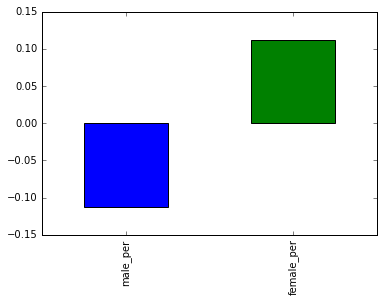

In [21]:
# analyze the correlation of SAT score and gender
combined.corr()['sat_score'][['male_per', 'female_per']].plot.bar()

# Gender analysis

As shown in the bar plot above, there is a weak negative correlation of male_per and SAT score, while there is a weak positive correlation of female_per and SAT score.

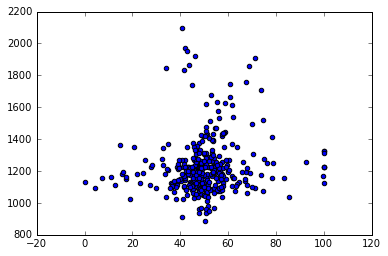

In [22]:
# visualize the relationship between female per and SAT score
plt.scatter(combined['female_per'], combined['sat_score'])

# Scatter plot findings

As shown in the scatter plot above, there is a weak positive correlation between female per and SAT scores. There is a high concentration of female per of approximately 50 percent and SAT scores around approximately 1200.

In [23]:
# find schools with high femail per and high SAT scores
high_female_per_high_sat = combined[combined['female_per'] > 60]
high_female_per_high_sat = high_female_per_high_sat[combined['sat_score'] > 1700]
high_female_per_high_sat[['SCHOOL NAME', 'female_per', 'sat_score']]

,SCHOOL NAME,female_per,sat_score
5,BARD HIGH SCHOOL EARLY COLLEGE,68.7,1856.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,67.5,1758.0
60,BEACON HIGH SCHOOL,61.0,1744.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,73.6,1707.0
302,TOWNSEND HARRIS HIGH SCHOOL,71.1,1910.0


# High female per findings

As seen in the table above, the are 2 interesting schools: an early college school, as well as a music and art school, which both have high SAT scores and female per.

In [24]:
# calculate percentage of AP test takers per school
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

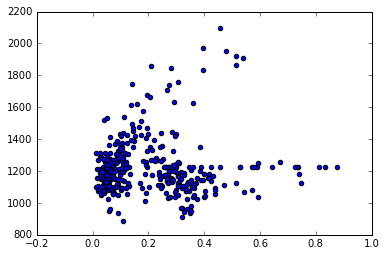

In [25]:
# show relationship between AP test takers percentage and SAT scores
plt.scatter(combined['ap_per'], combined['sat_score'])

# AP Test Takers observations

As shown in the scatter plot above, there appears to be a small positive correlation between the percentage of AP test takers and SAT scores.